In [1]:
!git clone https://mszarski:{}@github.com/mszarski/flatmesh

Cloning into 'flatmesh'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 4), reused 23 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [2]:
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (643 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...


In [3]:
!pip install ./flatmesh

Processing ./flatmesh
  Created wheel for flatmesh: filename=flatmesh-0.0.1-cp36-cp36m-linux_x86_64.whl size=5740181 sha256=3612884d11e3395e8f5dc6c1a79ef52eba97d7c09e614eed8ea043d74549279b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sqjqpw8y/wheels/e2/ce/d5/e541f72b10062c7b5699690828825b335938ca92f396cb0fff
Successfully built flatmesh


In [4]:
!pip install trimesh

     |████████████████████████████████| 634kB 8.0MB/s 


In [5]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [6]:
import trimesh
import numpy as np
from scipy.spatial import distance
import flatmesh
import matplotlib.pyplot as plt

In [158]:
curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/3d_shape.obj',process=False)

In [159]:
curved_mesh.show()

In [160]:
v = curved_mesh.vertices
f = curved_mesh.faces

# p0 = 0
# distances = distance.cdist(v, [v[p0]], 'euclidean')
# p1 = distances.argmax()
# dist = distances[p1][0]

p0 = 19
p1 = 302

flattener = flatmesh.FaceUnwrapper(v, f)
flattener.findFlatNodes(5, 0.99)
uv = flattener.ze_nodes

In [161]:
flat_vertices = np.vstack((uv[:,1], uv[:,0], np.zeros_like(uv[:,1]))).T

In [162]:
#align mesh constant seam in xy plane
v_flat = flat_vertices[p1] - flat_vertices[p0]
v_curved = v[p1] - v[p0]
v_curved[2] = 0.0
T, a = trimesh.geometry.align_vectors(v_curved, v_flat, return_angle=True)
flat_vertices = trimesh.transformations.transform_points(flat_vertices,T)

In [163]:
flat_mesh = trimesh.Trimesh(vertices=flat_vertices,
                       faces=curved_mesh.faces,
                       process=False)

In [164]:
com_delta = curved_mesh.centroid - flat_mesh.centroid
com_delta[2] = 0
flat_mesh.vertices = flat_mesh.vertices + com_delta

In [165]:
flat_mesh.show()

In [166]:
trimesh.repair.fix_normals(flat_mesh)

In [167]:
scene = trimesh.Scene([curved_mesh, flat_mesh])
scene.show(viewer='notebook')

In [168]:
flat_mesh.export('/content/drive/My Drive/draping_workspace/2d_shape_flatmesh.obj')

'# https://github.com/mikedh/trimesh\nv -31.97742050 -183.40004790 0.00000000\nv -22.51797173 -188.04244408 0.00000000\nv -30.88359324 -193.97423327 0.00000000\nv -79.63688831 153.21057106 0.00000000\nv -61.15952405 163.49723161 0.00000000\nv -51.04577279 146.13563854 0.00000000\nv -67.06877756 139.36575089 0.00000000\nv -42.91933830 171.66729427 0.00000000\nv -33.79772522 150.81607671 0.00000000\nv -23.36628990 178.37316268 0.00000000\nv -15.57831471 155.94682171 0.00000000\nv -3.49481820 183.11501946 0.00000000\nv 3.29284840 160.15627171 0.00000000\nv 18.69660232 186.05323980 0.00000000\nv 22.80816829 162.77058778 0.00000000\nv 38.60427335 186.66149546 0.00000000\nv 42.04833124 163.55342359 0.00000000\nv 59.50470788 185.30068352 0.00000000\nv 61.09556445 162.66487239 0.00000000\nv 79.44224257 182.13167574 0.00000000\nv 79.20115532 160.39446857 0.00000000\nv 98.62304563 177.38940398 0.00000000\nv 96.38960115 157.14747019 0.00000000\nv 116.29791783 171.56802295 0.00000000\nv 112.756509

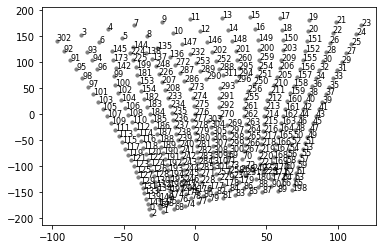

In [169]:
plt.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],c='grey',s=10)
for i in range(flat_mesh.vertices.shape[0]):
    plt.text(flat_mesh.vertices[i,0], flat_mesh.vertices[i,1], str(i),fontsize=8)

In [170]:
from trimesh import grouping
# we know that in a watertight mesh every edge will be included twice
# thus every edge which appears only once is part of a boundary
boundary_groups = grouping.group_rows(
    flat_mesh.edges_sorted, require_count=1)

boundary_edges = flat_mesh.edges[boundary_groups]
index_as_dict = [{'index': i} for i in boundary_groups]

import networkx as nx

# we create a graph of the boundary edges, and find cycles.
g = nx.from_edgelist(
    np.column_stack((boundary_edges,
                     index_as_dict)))
idxs = []
for vertex in nx.cycle_basis(g):
    idxs.append(vertex)


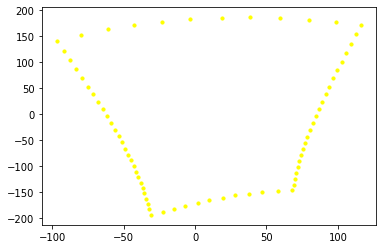

In [171]:
plt.scatter(flat_mesh.vertices[idxs,0],flat_mesh.vertices[idxs,1],c='yellow',s=10)

In [172]:
np.array(idxs)

array([[  2,   1,  68,  74,  77,  79,  81,  83,  85,  87,  89, 198,  65,
         63,  61,  59,  57,  55,  53,  51,  49,  47,  45,  43,  41,  39,
         37,  35,  33,  31,  29,  27,  25,  24,  23,  21,  19,  17,  15,
         13,  11,   9,   7,   4,   3, 302,  92,  91,  95,  98,  97, 101,
        103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127,
        129, 131, 133, 139, 141,   0]])

In [173]:
(curved_mesh.vertices[seed_point_index] - flat_mesh.vertices[seed_point_index])*0.01

TrackedArray([-0.00026488, -0.01153786,  0.221824  ])

In [104]:
#find one-ring etc
g = nx.from_edgelist(flat_mesh.edges_unique)
one_ring = [list(g[i].keys()) for i in idxs]
plt.scatter(flat_mesh.vertices[idxs,0],flat_mesh.vertices[idxs,1],c='yellow',s=10)
plt.scatter(flat_mesh.vertices[one_ring,0],flat_mesh.vertices[one_ring,1],c='blue',s=10)

TypeError: ignored

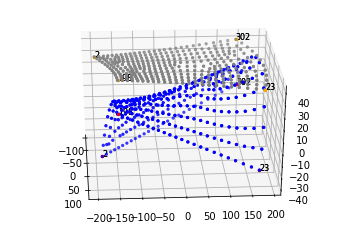

In [176]:
seed_point_index = 292
handles = [302, 198, 2, 23]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

from IPython.display import HTML
import matplotlib.animation as animation

def init():
    ax.scatter(flat_mesh.vertices[:,0],flat_mesh.vertices[:,1],flat_mesh.vertices[:,2]+40,c='grey',s=5)
    ax.scatter(curved_mesh.vertices[:,0],curved_mesh.vertices[:,1],curved_mesh.vertices[:,2],c='blue',s=5)
    for i in [*handles]:
        ax.scatter(flat_mesh.vertices[i,0],flat_mesh.vertices[i,1],flat_mesh.vertices[i,2]+40,c='orange',s=5)
        ax.text(flat_mesh.vertices[i,0], flat_mesh.vertices[i,1],flat_mesh.vertices[i,2]+40, str(i),fontsize=8)
        ax.scatter(curved_mesh.vertices[i,0],curved_mesh.vertices[i,1],curved_mesh.vertices[i,2],c='red',s=5)
        ax.text(curved_mesh.vertices[i,0],curved_mesh.vertices[i,1],curved_mesh.vertices[i,2], str(i),fontsize=8)
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)    

HTML(ani.to_html5_video())